### How To: Train a BPNet model using the Python API

In [1]:
seq = "/home/jmschrei/common/hg38.fa"
controls = ['ctcf-bpnet/ctcf-control.+.bw', 'ctcf-bpnet/ctcf-control.-.bw']
signals = ['ctcf-bpnet/ctcf.+.bw', 'ctcf-bpnet/ctcf.-.bw']

training_chroms = [
    "chr2", "chr4", "chr5", "chr7", "chr9", "chr10", "chr11", "chr12", 
    "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19",
    "chr21", "chr22", "chrX", "chrY"
]

validation_chroms = ['chr8', 'chr20']

peaks = 'ctcf-bpnet/ENCFF446MKT.bed.gz'
negatives = 'ctcf-bpnet/ctcf.negatives.bed'

In [2]:
from bpnetlite.io import PeakGenerator

training_data = PeakGenerator(
    peaks=peaks,
    negatives=negatives,
    sequences=seq,
    signals=signals,
    controls=controls,
    chroms=training_chroms,
    random_state=0,
    batch_size=64,
    verbose=True
)

Loading Loci: 100%|████████████████████████████████████████████████████████████| 28767/28767 [00:02<00:00, 10954.13it/s]



Filtered Peaks: 465
Filtered Negatives: 0


In [3]:
from bpnetlite.io import extract_loci

X_valid, y_valid, X_ctl_valid = extract_loci(
    sequences=seq,
    signals=signals,
    in_signals=controls,
    loci=peaks,
    chroms=validation_chroms,
    max_jitter=0,
    verbose=True
)

X_valid.shape, X_ctl_valid.shape, y_valid.shape

Loading Loci: 100%|██████████████████████████████████████████████████████████████| 2884/2884 [00:00<00:00, 11660.54it/s]


(torch.Size([2849, 4, 2114]),
 torch.Size([2849, 2, 2114]),
 torch.Size([2849, 2, 1000]))

In [4]:
from bpnetlite.bpnet import BPNet

model = BPNet(
    n_outputs=2,
    n_control_tracks=2,
    name='ctcf-bpnet/model',
    verbose=True
).cuda()

In [5]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,
	patience=5, threshold=0.0001, min_lr=0.0001)

In [7]:
model.fit(
    training_data, optimizer, scheduler,
    X_valid=X_valid, 
    X_ctl_valid=X_ctl_valid, 
    y_valid=y_valid, 
    max_epochs=50,
    batch_size=128,
    early_stopping=5,
    device='cuda'
)

Epoch	Iteration	Training Time	Validation Time	Training MNLL	Training Count MSE	Validation MNLL	Validation Profile Pearson	Validation Count Pearson	Validation Count MSE	Saved?
0	482	3.7701	0.2991	80.3868	1.2701	36.5776	0.020005899	0.51477605	0.4206	True
1	964	3.17	0.1198	34.8549	0.6422	35.8888	0.022540672	0.56076056	0.4176	True
2	1446	3.1653	0.1168	81.7908	0.8583	35.7601	0.02349824	0.58341587	0.3703	True
3	1928	3.16	0.1167	112.8121	0.8298	35.562	0.024235368	0.60519785	0.3861	True
4	2410	3.1642	0.1168	73.9087	1.0961	35.4992	0.024880849	0.6186896	0.3658	True
5	2892	3.1603	0.1172	41.9932	1.0487	35.4463	0.02516471	0.619967	0.3433	True
6	3374	3.1685	0.1341	18.2727	0.494	35.4356	0.025266113	0.6209223	0.3475	True
7	3856	3.1664	0.1197	86.5992	0.5216	35.3744	0.025643002	0.62280846	0.3475	True
8	4338	3.1776	0.1173	83.2661	0.6927	35.4447	0.025062477	0.6134318	0.3641	False
9	4820	3.1668	0.117	137.6518	0.4825	35.3897	0.025550406	0.6270957	0.3383	False
10	5302	3.1694	0.1173	34.8624	0.318	35.3135	0.02

In [8]:
import tarfile

from io import BytesIO
from bpnetlite.bpnet import BasePairNet

with tarfile.open("ctcf-bpnet/ENCFF500SSJ.tar.gz", "r:gz") as tar:
    model_tar = tar.extractfile("./fold_0/model.fold_0.ENCSR000DRR.h5").read()

official_bpnet = BasePairNet.from_bpnet(
    BytesIO(model_tar)
)

official_bpnet

BasePairNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)

In [10]:
from tangermeme.predict import predict

new_y_logits, new_y_logcounts = predict(model, X_valid, args=(X_ctl_valid,))
official_y_logits, official_y_logcounts = predict(official_bpnet, X_valid, args=(X_ctl_valid,))

In [15]:
from bpnetlite.performance import calculate_performance_measures

perfs1 = calculate_performance_measures(new_y_logits, y_valid, new_y_logcounts)
perfs2 = calculate_performance_measures(official_y_logits, y_valid, official_y_logcounts)

In [18]:
perfs1

{'profile_mnll': tensor([[ 5.6721,  0.0000],
         [15.7783, 29.6001],
         [12.4164,  5.8385],
         ...,
         [12.3177,  6.4522],
         [12.6433, 18.2610],
         [12.7764,  0.0000]]),
 'profile_jsd': tensor([[0.6817,    nan],
         [0.6676, 0.6716],
         [0.6833, 0.6832],
         ...,
         [0.6825, 0.6873],
         [0.6843, 0.6797],
         [0.6848,    nan]]),
 'profile_pearson': tensor([[0.1306, 0.0000],
         [0.0886, 0.0328],
         [0.0229, 0.0754],
         ...,
         [0.0262, 0.0192],
         [0.0164, 0.0298],
         [0.0142, 0.0000]]),
 'profile_spearman': tensor([[ 0.3500, -0.2911],
         [ 0.4910,  0.4573],
         [ 0.1943,  0.0306],
         ...,
         [ 0.0116,  0.1142],
         [ 0.0227,  0.3741],
         [ 0.2475,  0.0559]]),
 'count_pearson': tensor([0.6257]),
 'count_spearman': tensor([0.5456]),
 'count_mse': tensor([0.3634])}

In [19]:
perfs2

{'profile_mnll': tensor([[ 6.0225,  0.0000],
         [14.1934, 29.7309],
         [12.3776,  5.8578],
         ...,
         [12.0519,  5.8443],
         [12.6479, 17.8566],
         [13.0853,  0.0000]]),
 'profile_jsd': tensor([[0.6846,    nan],
         [0.6530, 0.6697],
         [0.6831, 0.6833],
         ...,
         [0.6812, 0.6832],
         [0.6843, 0.6784],
         [0.6855,    nan]]),
 'profile_pearson': tensor([[0.0646, 0.0000],
         [0.1475, 0.0405],
         [0.0298, 0.0826],
         ...,
         [0.0288, 0.0546],
         [0.0209, 0.0514],
         [0.0054, 0.0000]]),
 'profile_spearman': tensor([[ 0.1324, -0.3376],
         [ 0.5698,  0.5168],
         [ 0.1785,  0.1319],
         ...,
         [-0.0318,  0.2407],
         [ 0.2324,  0.5450],
         [ 0.4979,  0.2479]]),
 'count_pearson': tensor([0.5982]),
 'count_spearman': tensor([0.4939]),
 'count_mse': tensor([0.7699])}

In [24]:
import numpy

numpy.nan_to_num(perfs1['profile_pearson']).mean(), numpy.nan_to_num(perfs2['profile_pearson']).mean()

(0.025711298, 0.024560869)

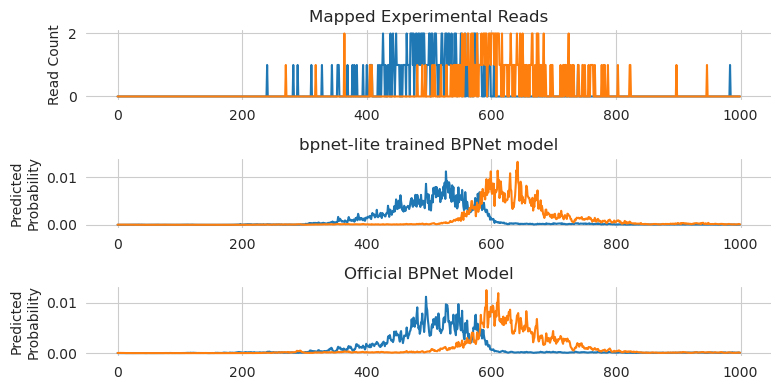

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.title("Mapped Experimental Reads")
plt.plot(y_valid[1793].T)
plt.ylabel("Read Count")
seaborn.despine(bottom=True, left=True)

plt.subplot(312)
plt.title("bpnet-lite trained BPNet model")
plt.plot(torch.softmax(new_y_logits[1793], dim=-1).T)
plt.ylabel("Predicted\nProbability")
seaborn.despine(bottom=True, left=True)

plt.subplot(313)
plt.title("Official BPNet Model")
plt.ylabel("Predicted\nProbability")
plt.plot(torch.softmax(official_y_logits[1793], dim=-1).T)
seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

In [61]:
from tangermeme.deep_lift_shap import deep_lift_shap

from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper

X_attr0 = deep_lift_shap(CountWrapper(ControlWrapper(model)), X_valid[1793:1794])
X_attr1 = deep_lift_shap(CountWrapper(ControlWrapper(official_bpnet)), X_valid[1793:1794])

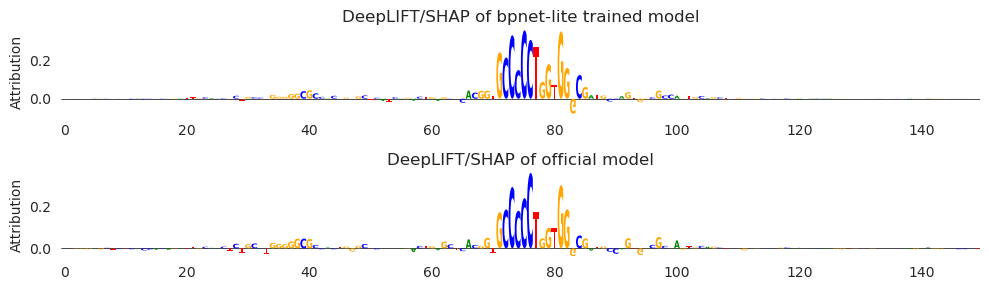

In [71]:
from tangermeme.plot import plot_logo

plt.figure(figsize=(10, 3))
plt.subplot(211)
plt.title("DeepLIFT/SHAP of bpnet-lite trained model")
plt.ylabel("Attribution")
plot_logo(X_attr0[0, :, 1050:1200])
plt.grid(False)

plt.subplot(212)
plt.title("DeepLIFT/SHAP of official model")
plt.ylabel("Attribution")
plot_logo(X_attr1[0, :, 1050:1200])
plt.grid(False)



plt.tight_layout()
plt.show()